In [2]:
library(SummarizedExperiment)
library(ggplot2)
source("../../code/utils.R")
source("../../code/getCounts.R")
source("../../code/visualization.R")
source("../../code/getFootprints.R")
library(patchwork)
library(ggrastr)
myPath <- .libPaths()
myPath <- c(myPath,'/home/yanhu/utils/R/R_packages')
.libPaths(myPath)

### Load input data

In [17]:
# Load differential nucleosome results
subpop_selection <- "Mk-biased" # Use "" if using all subpopulations, or "Mk-biased" and "multi-lineage" for specific subpops
diffNuc <- read.table(
  paste0("/home/yanhu/data/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome/diff_nucleosomes_",
         subpop_selection, ".tsv"),
  sep = "\t", header = T, row.names = 1
)

# Calculate FDRs
diffNuc$score_fdr <- p.adjust(diffNuc$score_pval, method = "fdr")
diffNuc$pos_fdr <- p.adjust(diffNuc$pos_pval, method = "fdr")

# Load cCRE ranges
regions <- readRDS("/home/yanhu/data/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome/regionRanges.rds")

In [18]:
# We bagged de novo and cisBP motifs to obtain a full list
# We only keep the representative motif from each bag
baggingPath <- "/home/yanhu/data/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome/de_novo_motifs/denovo_cisbp_bagging_representative.txt"
keptMotifs <- read.table(baggingPath, sep = "\t")$V1
keptMotifs <- stringr::str_replace_all(keptMotifs, "-", "_")

# Load motif match locations of de-novo motifs
TFMotifSites <- data.table::fread(
    "/data/yanhu/PRINT_rev/mouse_HSC/denovo_hits.bed",
    showProgress = T, nThread = 8
)
TFMotifSites <- TFMotifSites[TFMotifSites$motif_name %in% keptMotifs,]

# Convert to a GRanges object
denovoTFs <- unique(TFMotifSites$motif_name)
TFMotifRanges <- pbmcapply::pbmclapply(
    denovoTFs,
    function(TF){
        sites <- TFMotifSites[TFMotifSites$motif_name == TF, ]
        GRanges(seqnames = sites$chr, ranges = IRanges(start = sites$start, end = sites$end))
    },
    mc.cores = 8
)
names(TFMotifRanges) <- denovoTFs

# Also include known cisBP motifs
TFMotifRanges <- c(
    TFMotifRanges,
    readRDS("/home/yanhu/data/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome/TFMotifRanges.rds")
)
TFMotifRanges <- TFMotifRanges[names(TFMotifRanges) %in% keptMotifs]
keptMotifs <- names(TFMotifRanges)

png 
  2

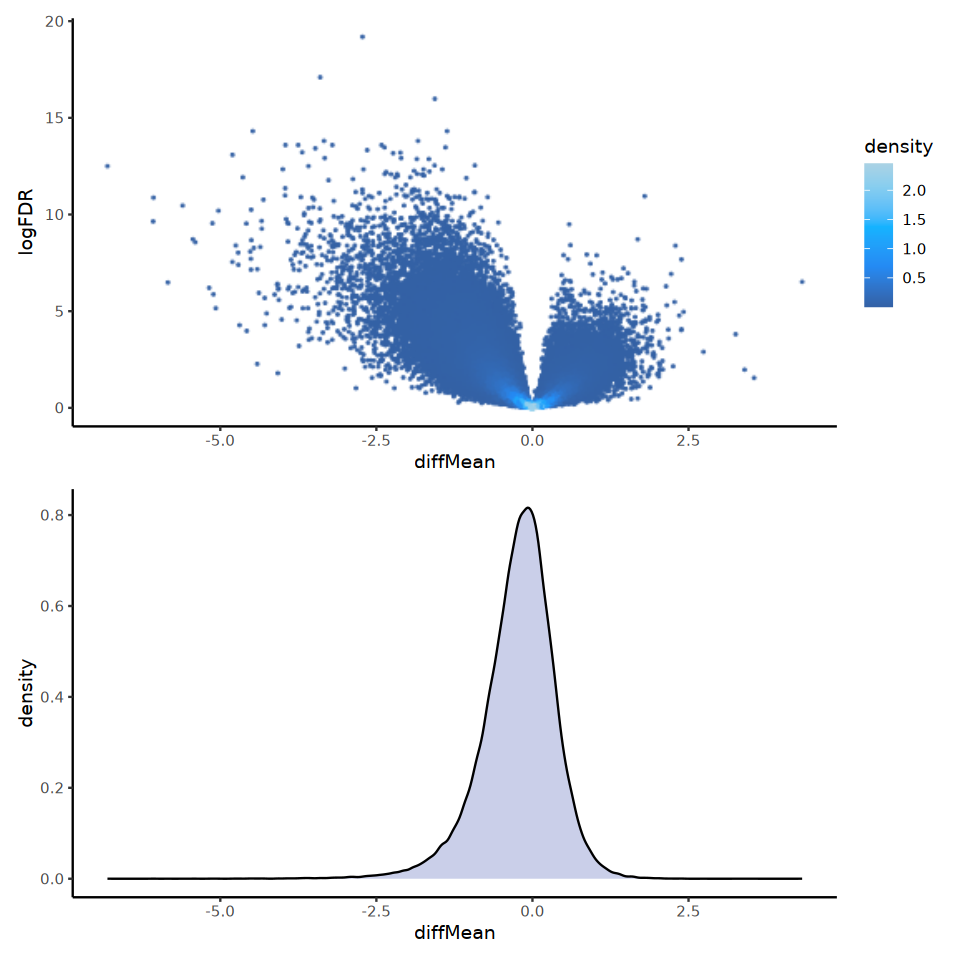

In [19]:
plotData <- data.frame(
    diffMean = diffNuc[,"mean_diff_score"],
    meanScore = diffNuc[,"mean_score"],
    logFDR = -log10(p.adjust(diffNuc[,"score_pval"], method = "fdr"))
)
plotData$density <- BuenColors::get_density(plotData$diffMean, plotData$logFDR)
options(repr.plot.width = 8, repr.plot.height =8)
p1 <- ggplot(plotData) +
    ggrastr::rasterise(geom_point(
        aes(x = diffMean, y = logFDR, color = density), size = 0.1)) +
    scale_color_gradientn(
        colors = BuenColors::jdb_palette("solar_extra"), 
        values = seq(0, quantile(plotData$density, 0.9), length.out = 8)) +
    theme_classic()
p2 <- ggplot(plotData) +
    geom_density(aes(x = diffMean), fill = "#cacfe9") +
    theme_classic()
pdf(paste0(
    "../../data//mHSCAging10xMultiome//plots/diff_nucleosomes/diff_distribution_",
    subpop_selection, ".pdf"), width = 8, height = 8)
p1 / p2
dev.off()
p1 / p2

In [20]:
# Convert to a GRanges object
diffNucRanges <- stringr::str_split_fixed(rownames(diffNuc), "[:-]", 4)
diffNucRanges <- GRanges(
    seqnames = diffNucRanges[, 1], 
    ranges = IRanges(
        start = as.integer(diffNucRanges[, 2]) + as.integer(diffNucRanges[, 4]),
        end = as.integer(diffNucRanges[, 2]) + as.integer(diffNucRanges[, 4])
    )
)
diffNucRanges <- resize(diffNucRanges, 1000, fix = "center")

In [21]:
# Whether to only focus on regions that are not differentially accessible during aging
nonDiffATAC <- F
if(nonDiffATAC){
  keptNuc <- 1:length(diffNucRanges)
  for(subpop in c("Mk-biased", "multi-lineage")){
    diffATAC <- read.table(paste0("../../data/mHSCAging10xMultiome/diffATAC_", subpop, ".tsv"))
    diffATAC <- diffATAC[(diffATAC$padj > 0.1),]
    keptNuc <- intersect(keptNuc, findOverlaps(
      GRanges(rownames(diffATAC)), 
      resize(diffNucRanges, 1, fix = "center")
    )@to)
  }
  diffNuc <- diffNuc[keptNuc, ]
  diffNucRanges <- diffNucRanges[keptNuc, ]
}

### Comput motif enrichment in regions with differential nucleosomes

In [22]:
# Create RangedSummarizedExperiment object for footprint data
nucSE <- SummarizedExperiment(
    list(counts = as.matrix(cbind(diffNuc$mean_score, diffNuc$mean_score))), # ChromVAR does not accept a single column so we make a fake second column
    rowRanges = diffNucRanges
)
rownames(nucSE) <- as.character(rowRanges(nucSE))

# Add GC bias
nucSE <- chromVAR::addGCBias(nucSE, genome=BSgenome.Mmusculus.UCSC.mm10::BSgenome.Mmusculus.UCSC.mm10)

# Impute NA GC bias values with the mean of the rest of the values
bias <- nucSE@rowRanges$bias
nucSE@rowRanges$bias[is.na(bias)] <- mean(bias[!is.na(bias)])

# Find background peaks with matched GC content and accessibility
bgPeaks <- chromVAR::getBackgroundPeaks(nucSE,niterations=100) 

In [23]:
# Find motif matches
motifMatches <- pbmcapply::pbmcmapply(
  function(TF){
    matchedInds <- unique(findOverlaps(rowRanges(nucSE), TFMotifRanges[[TF]])@from)
    matchVec <- rep(0, dim(nucSE)[1])
    matchVec[matchedInds] <- 1
    matchVec
  },
  names(TFMotifRanges),
  mc.cores = 8
)
colnames(motifMatches) <- sapply(keptMotifs, function(x){stringr::str_replace_all(x, "_", "-")})

In [24]:
# Find regions contaning differential nucleosomes as foreground
filter <- (diffNuc$mean_diff_score < -1) & (diffNuc$score_fdr < 0.01)
fgRegions <- unique(findOverlaps(rowRanges(nucSE), diffNucRanges[filter])@from)

In [25]:
enrichment <- BuenRTools::motifPeakZtest(
  peakSet = fgRegions,
  bgPeaks = bgPeaks,
  tfMat = motifMatches 
)

Getting selected peak motif frequencies ..
Getting background peak motif frequencies ..
Calculating empirical p values and z score p values ..


One or more provided motif IDs do not contain any '_' characters .. returning IDs as is

One or more provided motif IDs do not contain any '_' characters .. returning IDs as is

One or more provided motif IDs do not contain any '_' characters .. returning IDs as is

One or more provided motif IDs do not contain any '_' characters .. returning IDs as is

One or more provided motif IDs do not contain any '_' characters .. returning IDs as is

One or more provided motif IDs do not contain any '_' characters .. returning IDs as is

One or more provided motif IDs do not contain any '_' characters .. returning IDs as is

One or more provided motif IDs do not contain any '_' characters .. returning IDs as is

One or more provided motif IDs do not contain any '_' characters .. returning IDs as is

One or more provided motif IDs do not contain any '_' characters .. returning IDs as is

One or more provided motif IDs do not contain any '_' characters .. returning IDs as is

One or more provided 

In [26]:
# For visualization, rename each de-novo motif
denovoTable <- read.table(
    "/home/yanhu/data/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome/de_novo_motifs/denovo_res2_all.txt", 
    sep = "\t", header = T)
enrichment$motifID <- stringr::str_replace_all(enrichment$motifID, "-", "_")
enrichment$gene <- enrichment$motifID

# Among TFs in enrichment results, find de novo ones
renameInds <- enrichment$gene %in% denovoTable$name

# Obtain their index in the full de novo motif list
renameDenovoInds <- match(enrichment$gene[renameInds], denovoTable$name)
enrichment$motifID[renameInds] <- paste0("denovo_motif_", renameDenovoInds)

# Retrieve their best matched known motifs
enrichment$gene[renameInds] <- denovoTable$new_name[renameDenovoInds]

# Also keep the original ID
enrichment$motifID_raw <- rownames(enrichment)

In [27]:
# Load cisBP aging chromVAR differential test results. (Original file name, exo.tsv)
cisBPTable <- read.table(
    "/home/yanhu/data/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome/de_novo_motifs/cisBP_aging_chromVAR_stats.tsv",
    sep = "\t", header = T
)
cisBPTable$TF <- sapply(
    cisBPTable$cluster,
    function(TF){
        stringr::str_split(TF, "_")[[1]][3]
    }
)
rownames(cisBPTable) <- cisBPTable$TF

In [28]:
# For each TF, retrieve aging differential chromVAR score test statistic
enrichment$aging_stat <- sapply(
    1:dim(enrichment)[1],
    function(i){
        if(stringr::str_detect(enrichment$motifID[i], "denovo")){
            denovoTable$stats[match(
                stringr::str_replace_all(enrichment$motifID_raw[i], "-", "_"),
                denovoTable$name)]
        }else{
            cisBPTable[enrichment$motifID[i], ]$stats
        }
    }
)

In [29]:
enrichment <- enrichment[order(-enrichment$z_test), ]
enrichment$FDR <- p.adjust(enrichment$pval.z, method = "fdr")
plotData <- data.frame(
    TF = sapply(
        1:dim(enrichment)[1],
        function(i){
            if(stringr::str_detect(enrichment$gene[i], "unknown")){
                enrichment$motifID[i]
            }else{
                enrichment$gene[i]
            }
        }
    ),
    score = sign(enrichment$z_test) * -log10(enrichment$FDR),
    aging_stat = enrichment$aging_stat
)

# Select TFs going up or down in aging
group <- "up_in_aging" # Can be "up_in_aging" or "down_in_aging"
if(group == "up_in_aging"){
    plotData <- plotData[plotData$aging_stat > 0, ]
}else if(group == "down_in_aging"){
    plotData <- plotData[plotData$aging_stat < 0, ]
}

# Visualize results
plotData <- plotData[10:1, ]
plotData$TF <- factor(plotData$TF, levels = plotData$TF) # This keeps the entries in the original order when plotting
p <- ggplot(plotData) +
  geom_bar(aes(x = TF, y = score), stat = "identity", width = 0.5, fill = "#CA9B80") +
  ylab("Enrichment -log10(FDR)") +
  coord_flip() +
  theme_classic() +
  ggtitle(group) +
  theme(axis.text = element_text(size = 10))  
if(nonDiffATAC){
    pdf(paste0("../../data/mHSCAging10xMultiome/plots/diff_nucleosomes/motif_enrichment_combined_", 
               group, "_nonDiffATAC_", subpop_selection, ".pdf"), width = 10, height = 6)
}else{
    pdf(paste0("../../data/mHSCAging10xMultiome/plots/diff_nucleosomes/motif_enrichment_combined_",
               group, "_", subpop_selection, ".pdf"), width = 10, height = 6)
}
p
dev.off()

png 
  2

In [30]:
topTFs <- enrichment$gene[order(-enrichment$z_test)][1:10]
topTFs

[1] "Thap1,Mbtps2,Yy1,Yy2,Taf1,Zfp42" "Ctcf,Ctcfl"                     
 [3] "Nrf1"                            "unknown_maybeLin28a_0.89"       
 [5] "Zfx,Zfp64,Mxd1,Mxi1"             "unknown_maybeSp2_0.81"          
 [7] "unknown_maybeZbtb33_0.80"        "unknown_maybeZkscan6_1.00"      
 [9] "unknown_maybeZik1_1.00"          "unknown_maybeSmad1_0.11"

In [34]:
write.table(
    enrichment, 
    paste0("../../data/mHSCAging10xMultiome/de_novo_motifs/diff_nucleosome_motif_enrichment_cisBP_and_denovo_", 
           subpop_selection, ".tsv"), 
    sep = "\t", quote = F, row.names = F, col.names = T
)

### Compare results of different subpopulations

In [53]:
subpops <- c("Mk-biased", "multi-lineage")
enrichment_list <- lapply(
    subpops,
    function(subpop){
        enrichment <- read.table(
            paste0("../../data/mHSCAging10xMultiome/de_novo_motifs/diff_nucleosome_motif_enrichment_cisBP_and_denovo_", 
                   subpop, ".tsv"),
            sep="\t", header=T
        )
        rownames(enrichment) <- enrichment$motifID
        enrichment
    }
)
names(enrichment_list) <- subpops

# Make sure the TFs are in the same order
TFs <- sort(rownames(enrichment_list[["Mk-biased"]]))
for(subpop in subpops){
    enrichment_list[[subpop]] <- enrichment_list[[subpop]][TFs,]
}

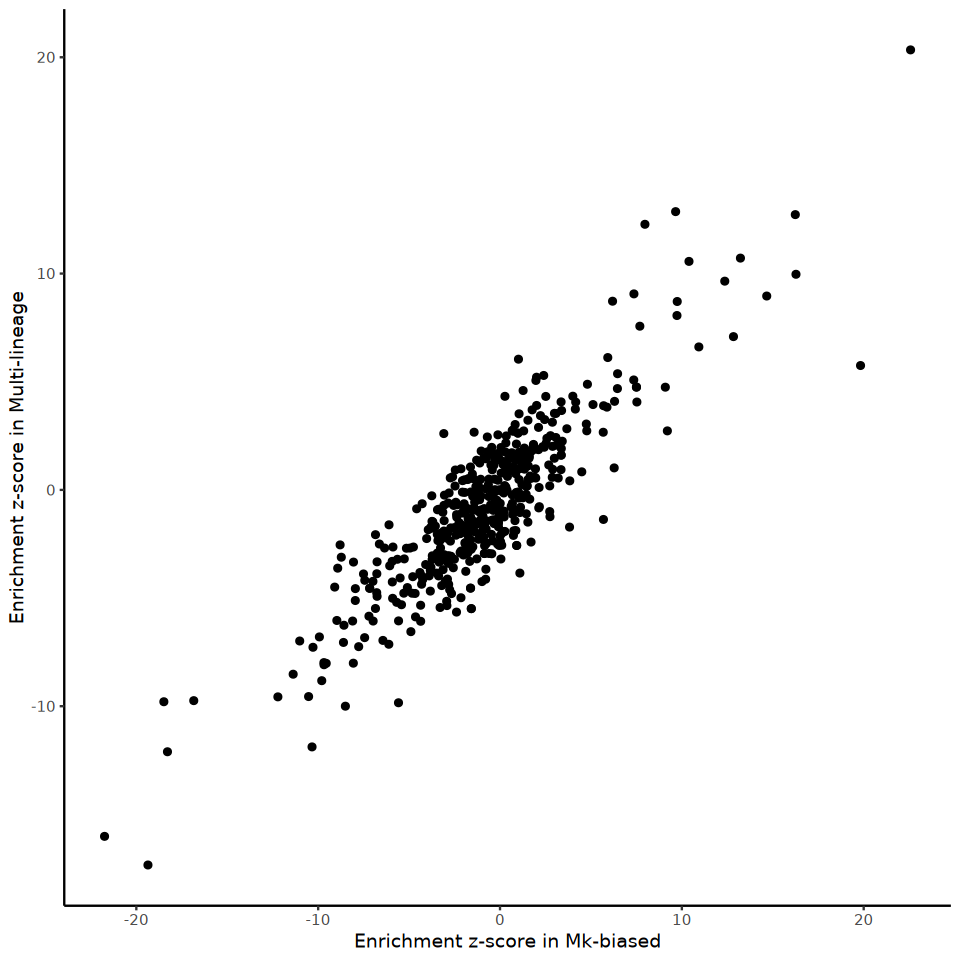

In [59]:
plotData <- data.frame(
    Mkbias_stats = enrichment_list$`Mk-biased`$z_test,
    multilineage_stats = enrichment_list$`multi-lineage`$z_test
)
ggplot(plotData) +
    geom_point(aes(x=Mkbias_stats, y=multilineage_stats)) +
    xlab("Enrichment z-score in Mk-biased") +
    ylab("Enrichment z-score in Multi-lineage") +
    theme_classic()


### Examine overlap between diff nucleosomes and diff accessibility regions

In [14]:
# First keep only the regions covered by both differential accessibility and nucleosome tracking analyses
diffATAC <- read.table("../../data/mHSCAging10xMultiome/diffATAC_all.tsv", sep = "\t")
diffATACRanges <- GRanges(rownames(diffATAC))
keptRegions <- subsetByOverlaps(regions, diffNucRanges)
keptRegions <- subsetByOverlaps(keptRegions, diffATACRanges)

# Next count the number of such regions with differential nucleosomes
filter <- diffNuc$score_fdr < 0.01
nucDiff <- unique(findOverlaps(keptRegions, diffNucRanges[filter])@from)
numNucDiff <- length(nucDiff)

# Also count the number of such regions that show differential accessibility
accDiff <- unique(findOverlaps(keptRegions, diffATACRanges[diffATAC$padj < 0.01])@from)
numAccDiff <- length(accDiff)

print(numNucDiff)
print(numAccDiff)
print(length(intersect(nucDiff, accDiff)))

[1] 29745
[1] 27398
[1] 18494


In [15]:
diffATAC$logFDR <- -log10(diffATAC$padj)

png 
  2

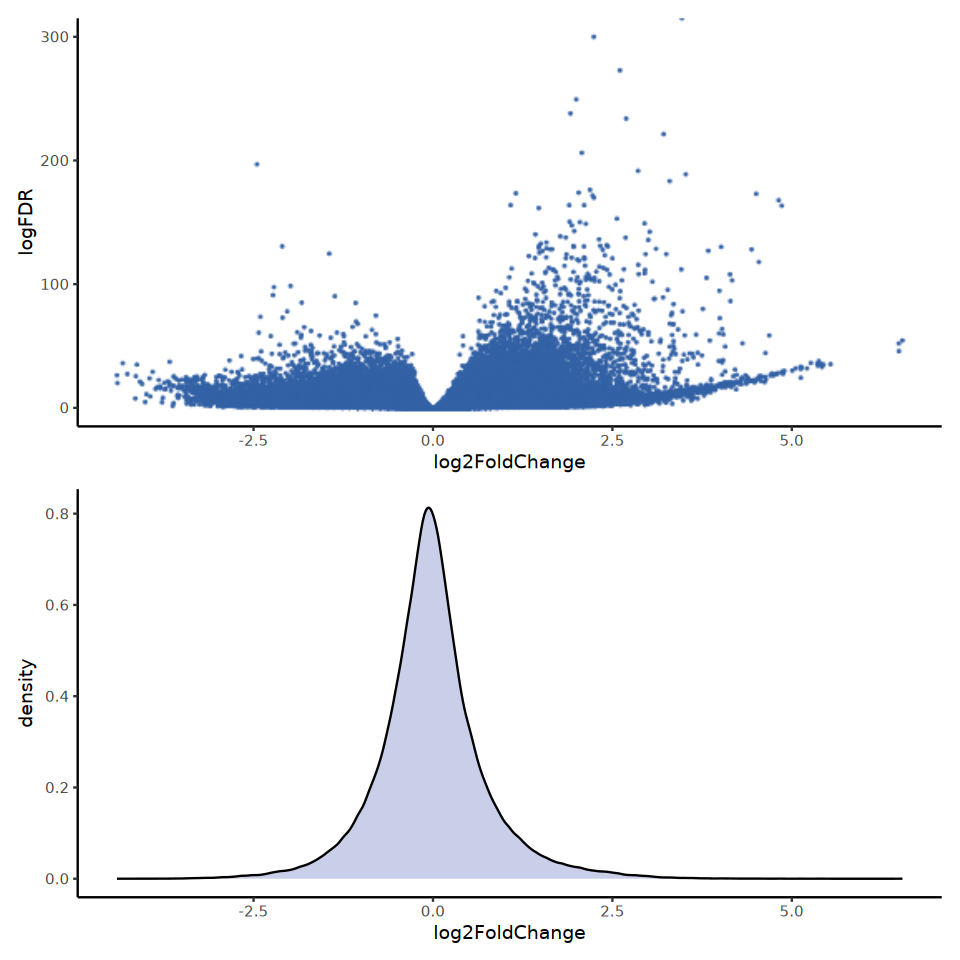

In [16]:
# As a comparison, also visualize the volcano plot for diff accessibility
plotData <- diffATAC
#plotData$density <- BuenColors::get_density(plotData$log2FoldChange, plotData$logFDR)
options(repr.plot.width = 8, repr.plot.height =8)
p1 <- ggplot(plotData) +
    ggrastr::rasterise(geom_point(
        aes(x = log2FoldChange, y = logFDR), size = 0.1, color = "#3261a5")) +
    theme_classic()
p2 <- ggplot(plotData) +
    geom_density(aes(x = log2FoldChange), fill = "#cacfe9") +
    theme_classic()
pdf(paste0(
        "../../data//mHSCAging10xMultiome//plots/diff_nucleosomes/diff_distribution_accessibility.pdf"), width = 8, height = 8)
p1 / p2
dev.off()
p1 / p2